In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tensorflow
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint
from keras.applications.mobilenet_v2 import  preprocess_input

In [2]:
train_df=pd.read_csv('annotations.csv')

In [3]:
import zipfile
import os
files = zipfile.ZipFile('images.zip','r')
files.extractall(os.getcwd())

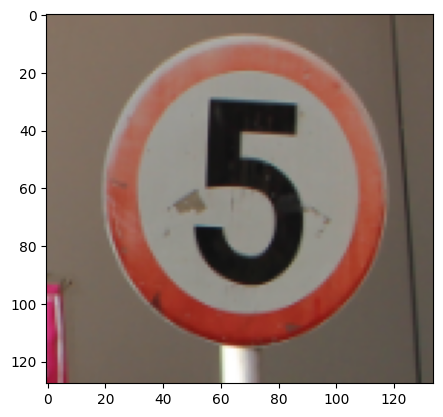

In [4]:
path='images/000_0001.png'
img=plt.imread(path)
plt.imshow(img)

In [5]:
train_df['category'] = train_df['category'].astype('str')

In [6]:
datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=preprocess_input,
            validation_split=0.1,
            featurewise_center=False,
            featurewise_std_normalization=False,
            rotation_range=15,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True           
            )

In [7]:
# Train generator
train_generator = datagen.flow_from_dataframe(
            dataframe=train_df,
            directory="images",
            x_col="file_name",
            y_col="category",
            has_ext=False,
            subset="training",
            batch_size=16,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size=(224,224))

Found 5548 validated image filenames belonging to 58 classes.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/miniconda3/lib/python3.9/logging/__init__.py", line 1083, in emit
    msg = self.format(record)
  File "/usr/local/miniconda3/lib/python3.9/logging/__init__.py", line 927, in format
    return fmt.format(record)
  File "/usr/local/miniconda3/lib/python3.9/logging/__init__.py", line 663, in format
    record.message = record.getMessage()
  File "/usr/local/miniconda3/lib/python3.9/logging/__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/local/miniconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/miniconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/usr/local/miniconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/usr/local/m

In [8]:
val_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=preprocess_input,
            validation_split=0.1,          
            )

In [9]:
# Validation generator
val_generator = val_datagen.flow_from_dataframe(
            dataframe=train_df,
            directory='images',
            x_col="file_name",
            y_col="category",
            has_ext=False,
            subset="validation",
            batch_size=16,
            seed=42,
            shuffle=False,
            class_mode="categorical",
            target_size=(224,224)) 

Found 616 validated image filenames belonging to 58 classes.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/miniconda3/lib/python3.9/logging/__init__.py", line 1083, in emit
    msg = self.format(record)
  File "/usr/local/miniconda3/lib/python3.9/logging/__init__.py", line 927, in format
    return fmt.format(record)
  File "/usr/local/miniconda3/lib/python3.9/logging/__init__.py", line 663, in format
    record.message = record.getMessage()
  File "/usr/local/miniconda3/lib/python3.9/logging/__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/local/miniconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/miniconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/usr/local/miniconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/usr/local/m

In [10]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('TSR_model.h5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop,Reduce_LR]

In [11]:
mobileNet=MobileNetV2(include_top=False,input_shape=(224,224,3),weights='imagenet')

2023-01-15 17:54:51.350799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 17:54:51.356975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 17:54:51.357815: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 17:54:51.359349: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
mobileNet.trainable=False

In [13]:
model = Sequential()
model.add(mobileNet)
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(units = 1024 , activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(units = 58 , activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 512)               32113152  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4

In [14]:
model.compile(optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99),loss='categorical_crossentropy', metrics=["accuracy"])

In [15]:
history=model.fit(train_generator,validation_data=val_generator,epochs=100,batch_size=16,
                  steps_per_epoch=len(train_generator)//16,validation_steps=len(val_generator)//16,
                  callbacks=callback, verbose=1)

Epoch 1/100


2023-01-15 17:54:57.197940: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201
2023-01-15 17:54:57.866403: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


21/21 [==============================] - 10s 246ms/step - loss: 3.4008 - accuracy: 0.2827 - val_loss: 16.5380 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
21/21 [==============================] - 4s 188ms/step - loss: 2.0805 - accuracy: 0.4881 - val_loss: 9.9733 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
21/21 [==============================] - 4s 191ms/step - loss: 1.7091 - accuracy: 0.5357 - val_loss: 8.3599 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
21/21 [==============================] - 4s 192ms/step - loss: 1.7099 - accuracy: 0.5476 - val_loss: 7.2209 - val_accuracy: 0.0625 - lr: 0.0010
Epoch 5/100
21/21 [==============================] - 4s 191ms/step - loss: 1.3708 - accuracy: 0.6399 - val_loss: 5.2262 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/100
21/21 [==============================] - 4s 188ms/step - loss: 1.1859 - accuracy: 0.6488 - val_loss: 4.5193 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 7/100
21/21 [==============================] - 4s 19

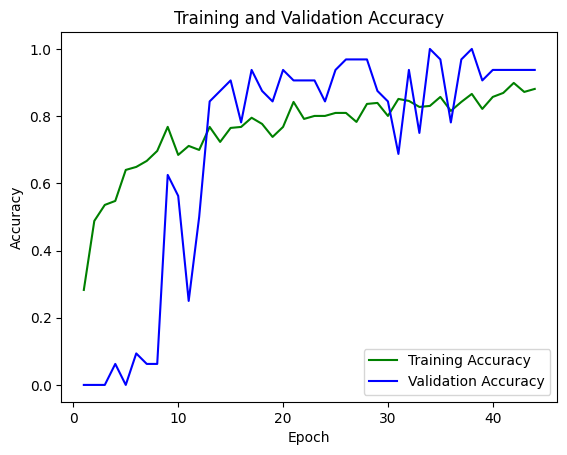

<Figure size 640x480 with 0 Axes>

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
#plot accuracy
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.figure()
plt.show()

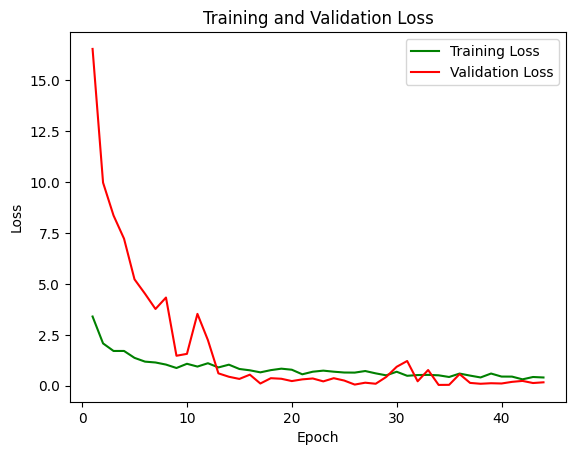

In [17]:
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
loss,acc=model.evaluate(val_generator)

39/39 [==============================] - 1s 36ms/step - loss: 0.6108 - accuracy: 0.8149
